- **In the first python notebook `1_simple_graph.ipynb` we have defined a simple Graph with Nodes, Edges, built a StateGraph and compiled it.**

- **Now, lets build a conditional Graph as defined in the below image.**

- **Graph State takes amount_usd as an input and based on the target currency, it will call a different node.**

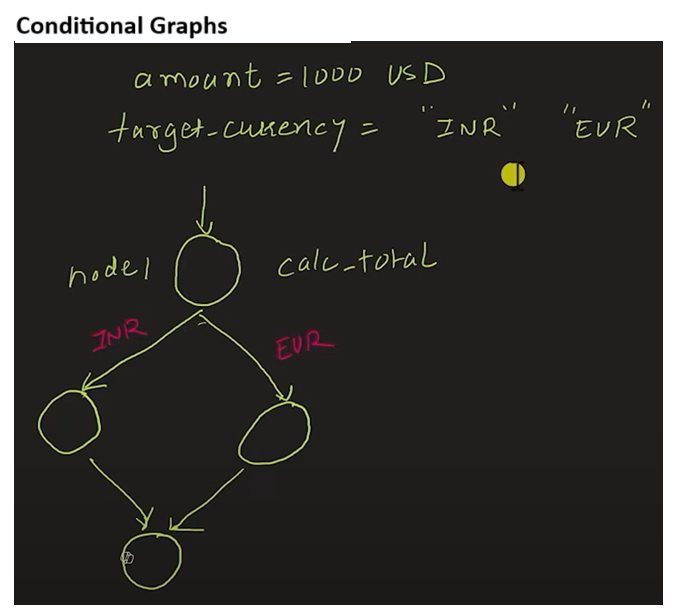

In [1]:
## TypedDict: Creates a dictionary-like class with defined structure and type hints
## Literal  : Restricts values to specific literal options (enables type-safe conditional logic)

from typing import TypedDict, Literal

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    target_currency: Literal["INR", "EUR"]
    total: float

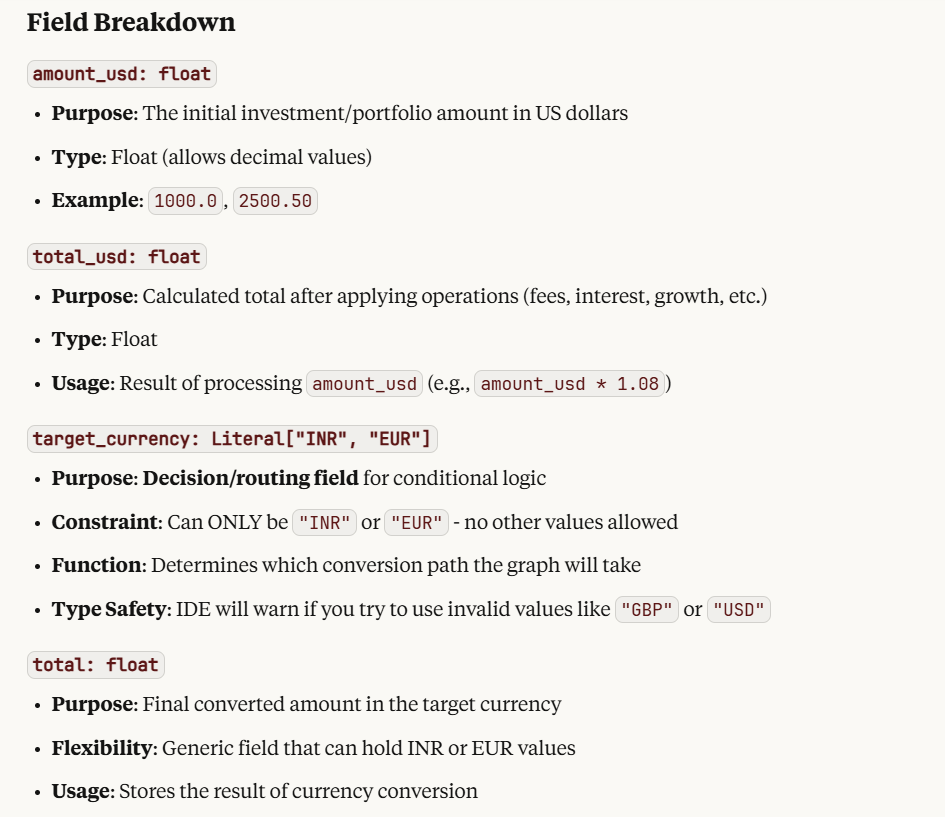

In [2]:
## Lets define the Nodes now in Langgraph which is nothing but a simple Python Function which takes State as an input/parameter

def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 85
    return state

def convert_to_eur(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 0.9
    return state

def choose_conversion(state: PortfolioState) -> str:
    return state["target_currency"]

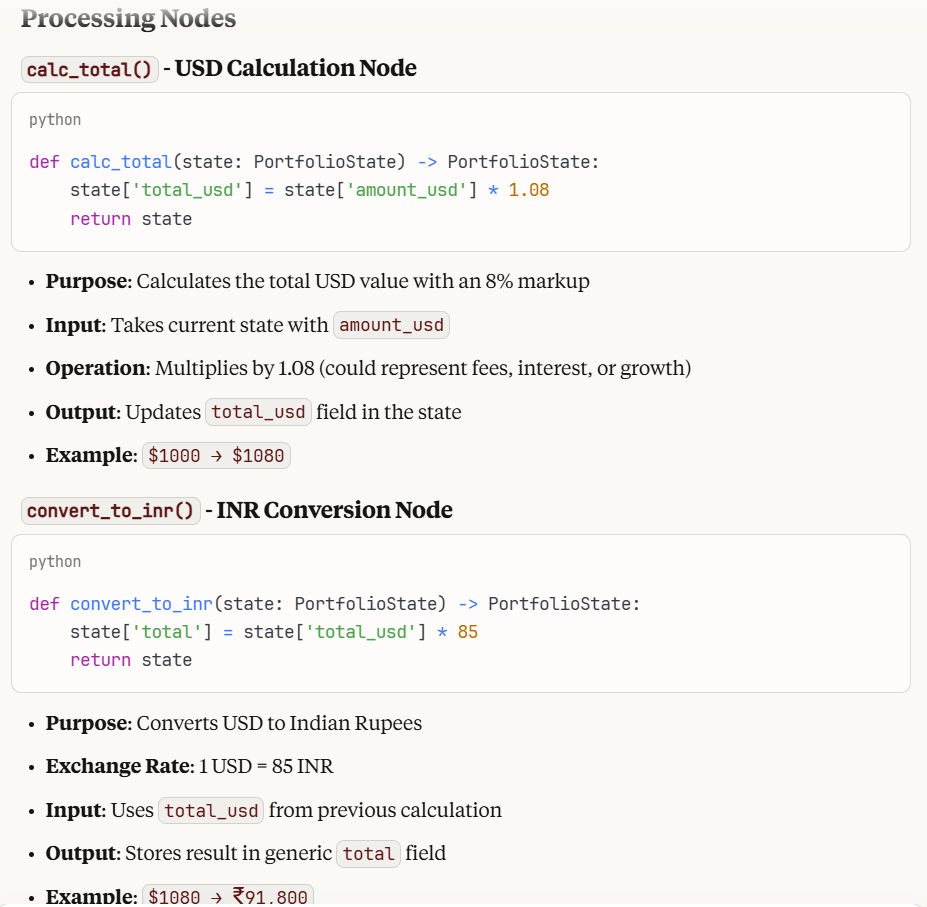
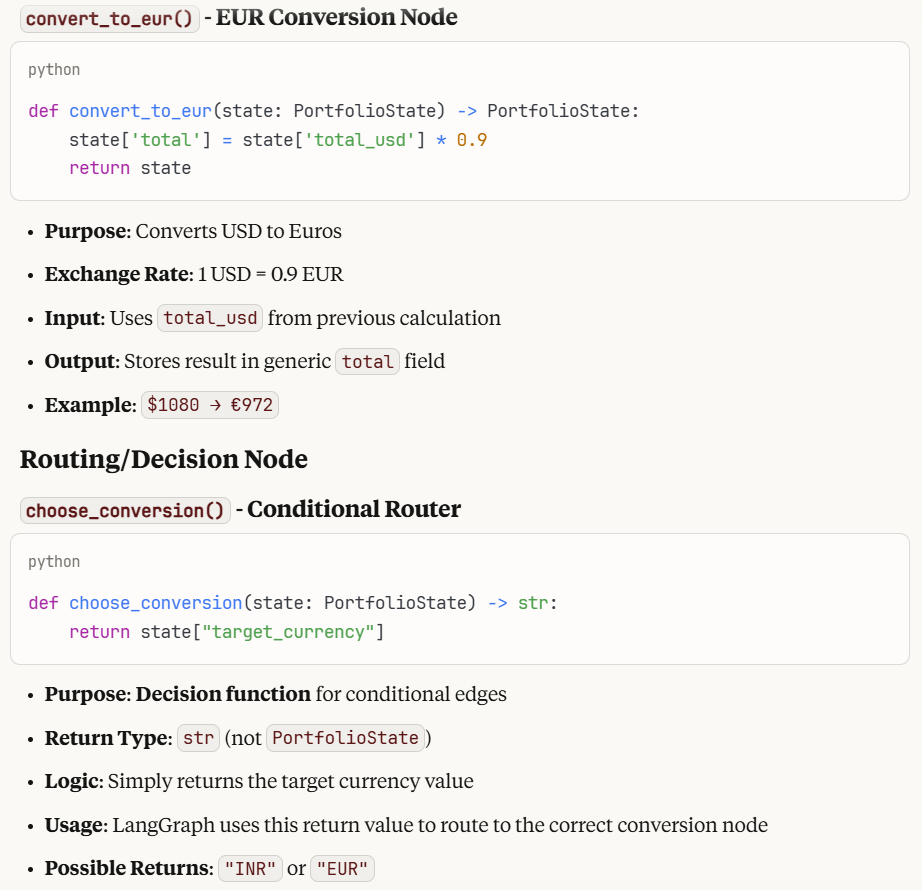

In [3]:
## A StateGraph object defines the structure of our chatbot as a "state machine". 
## We'll add nodes to represent the llm and functions our chatbot can call and edges, conditional edges to specify how the bot should transition between these functions.

from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

# Add processing nodes
builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)
builder.add_node("convert_to_eur_node", convert_to_eur)

# Linear flow to calculation
builder.add_edge(START, "calc_total_node")

# Conditional routing based on target currency
builder.add_conditional_edges(
    "calc_total_node",
    choose_conversion,  # Router function
    {
        "INR": "convert_to_inr_node",  # If returns "INR"
        "EUR": "convert_to_eur_node"   # If returns "EUR"
    }
)

# Both paths end the workflow
builder.add_edge("convert_to_inr_node", END)
builder.add_edge("convert_to_eur_node", END)

## builder.add_edge(["convert_to_inr_node", "convert_to_eur_node"], END)

graph = builder.compile()

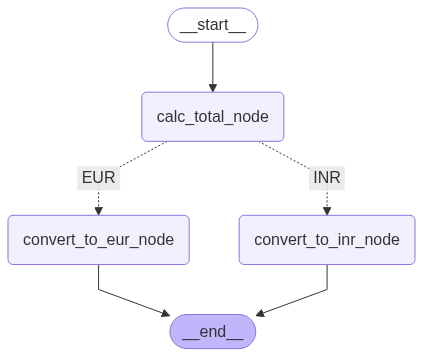

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

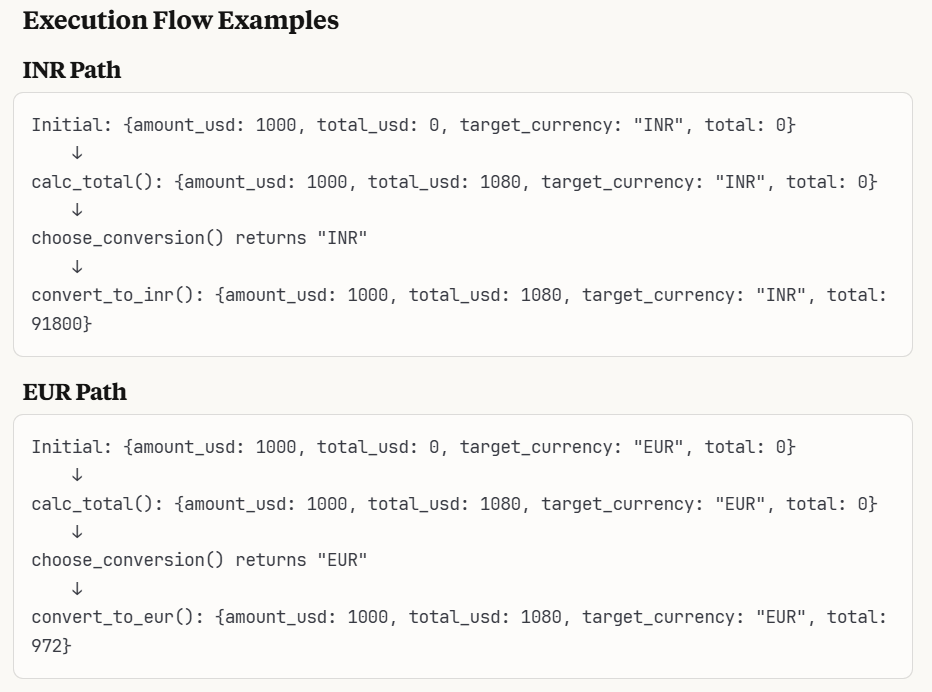

In [5]:
graph.invoke({"amount_usd": 1000, "target_currency": "INR"})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'INR',
 'total': 91800.0}

In [6]:
graph.invoke({"amount_usd": 1000, "target_currency": "EUR"})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'EUR',
 'total': 972.0}